In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
df_events = pd.read_csv('/content/drive/MyDrive/PhD/processedEvents/Consolidated_events.csv', encoding='utf-8')
print(df_events.shape)
print(df_events['label'].value_counts())

(480707, 12)
label
1    260777
0    219930
Name: count, dtype: int64


In [4]:
max_len = 20
epochs = 100
lr=.0001
batch_size=1000
patience=5
activationFunction='relu' #sigmoid
lossFunc = 'binary_crossentropy' #mse

###FastText Model Training

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import FastText
import pandas as pd
model = FastText(df_events['eid'].str.split(), min_count=5, window=5, vector_size=100, workers=4, min_n=1, max_n=4)

RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

In [ ]:
model.save('/content/drive/MyDrive/PhD/models/FastText.bin')

NameError: name 'model' is not defined

In [ ]:
fasttext_model = FastText.load('/content/drive/MyDrive/PhD/models/FastText.bin')

In [ ]:
fasttext_model.wv.most_similar("fnl", topn =10)

RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

###Test Train Split

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_events['eid'], df_events['label'], test_size = 0.20, random_state = 40)
print('x_train={}, ytrain={}, xtest={}, ytest={}'.format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

x_train=(384565,), ytrain=(384565,), xtest=(96142,), ytest=(96142,)


In [6]:
def preprocess_data(sequences, max_len):
  # Character-level tokenization (assuming character embeddings are used)
  import tensorflow
  tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(char_level=True)
  tokenizer.fit_on_texts(sequences)
  sequences_encoded = tokenizer.texts_to_sequences(sequences)
  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences_encoded, maxlen=max_len, padding='post')
  return padded_sequences, tokenizer.word_index

def create_embedding_matrix(word_index, fasttext_model):
  embedding_matrix = np.zeros((len(word_index) + 1, fasttext_model.vector_size))
  for char, i in word_index.items():
   # Directly use FastText model for embedding lookup (assuming character embeddings)
   embedding_matrix[i] = fasttext_model.wv[char] if char in fasttext_model.wv else np.zeros(fasttext_model.vector_size)
  return embedding_matrix

In [7]:
padded_sequences_train, word_index = preprocess_data(x_train.tolist(), max_len)
padded_sequences_test, word_index_test = preprocess_data(x_test.tolist(), max_len)

###FastText

In [ ]:
from gensim.models import FastText
fasttext_model = FastText.load('/content/drive/MyDrive/PhD/models/FastText.bin')
embedding_matrix = create_embedding_matrix(word_index, fasttext_model)

###LSTM

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_index) + 1,embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix]))
model_LSTM.add(LSTM(64, return_sequences=True))
model_LSTM.add(LSTM(32))
model_LSTM.add(Dense(1, activation=activationFunction))
model_LSTM.compile(loss=lossFunc,optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
import time
t0 = time.time()
H_LSTM = model_LSTM.fit(padded_sequences_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=epochs,callbacks=[EarlyStopping(monitor='loss',patience=patience)])
print("Training time : ", time.time()-t0)

Epoch 1/100
308/308 [==============================] - 38s 14ms/step - loss: 1.1158 - accuracy: 0.6287 - val_loss: 0.3913 - val_accuracy: 0.8924
Epoch 2/100
308/308 [==============================] - 3s 11ms/step - loss: 0.2921 - accuracy: 0.8976 - val_loss: 0.4550 - val_accuracy: 0.7659
Epoch 3/100
308/308 [==============================] - 6s 21ms/step - loss: 0.2552 - accuracy: 0.8982 - val_loss: 0.2159 - val_accuracy: 0.9148
Epoch 4/100
308/308 [==============================] - 4s 13ms/step - loss: 0.2079 - accuracy: 0.9148 - val_loss: 0.2058 - val_accuracy: 0.9162
Epoch 5/100
308/308 [==============================] - 3s 9ms/step - loss: 0.1999 - accuracy: 0.9154 - val_loss: 0.1991 - val_accuracy: 0.9161
Epoch 6/100
308/308 [==============================] - 6s 19ms/step - loss: 0.1952 - accuracy: 0.9149 - val_loss: 0.1946 - val_accuracy: 0.9150
Epoch 7/100
308/308 [==============================] - 4s 12ms/step - loss: 0.1880 - accuracy: 0.9291 - val_loss: 0.1791 - val_accuracy:

In [ ]:
from keras.models import save_model,load_model
save_model(model_LSTM, "/content/drive/MyDrive/PhD/models/model_LSTM",save_format='tf')
np.save('/content/drive/MyDrive/PhD/models/model_History_LSTM.npy',H_LSTM.history)
del model_LSTM

###CNN

In [ ]:
import tensorflow
from keras.layers import LSTM,Conv1D,Activation, Dense, MaxPooling1D,Dropout, Input, Embedding,Flatten,Bidirectional
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping
from keras import optimizers
model_CNN = Sequential()
model_CNN.add(Embedding(len(word_index) + 1, embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix]))
model_CNN.add(Conv1D(filters=32, kernel_size=16, activation=activationFunction, input_shape=(embedding_matrix.shape[1], 1)))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(1))
model_CNN.add(Activation(activationFunction))
model_CNN.compile(loss=lossFunc,optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
print(model_CNN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           900       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             51232     
                                                                 
 flatten_1 (Flatten)         (None, 160)               0         
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 52293 (204.27 KB)
Trainable params: 5229

In [ ]:
import time
t0 = time.time()
H_CNN = model_CNN.fit(padded_sequences_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=epochs,callbacks=[EarlyStopping(monitor='loss',patience=patience)])
print("Training time : ", time.time()-t0)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
from keras.models import save_model,load_model
save_model(model_CNN, "/content/drive/MyDrive/PhD/models/model_CNN",save_format='tf')
np.save('/content/drive/MyDrive/PhD/models/model_History_CNN.npy',H_CNN.history)
del model_CNN

###BiLSTM

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(len(word_index) + 1, embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix]))
model_BiLSTM.add(Bidirectional(LSTM(32)))
model_BiLSTM.add(Dense(1, activation=activationFunction))
model_BiLSTM.compile(loss=lossFunc,optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
import time
t0 = time.time()
H_BiLSTM = model_BiLSTM.fit(padded_sequences_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=epochs,callbacks=[EarlyStopping(monitor='loss',patience=patience)])
print("Training time : ", time.time()-t0)

Epoch 1/100
308/308 [==============================] - 8s 12ms/step - loss: 0.9573 - accuracy: 0.6091 - val_loss: 0.3537 - val_accuracy: 0.8651
Epoch 2/100
308/308 [==============================] - 3s 8ms/step - loss: 0.2567 - accuracy: 0.8906 - val_loss: 0.2046 - val_accuracy: 0.9172
Epoch 3/100
308/308 [==============================] - 3s 8ms/step - loss: 0.1964 - accuracy: 0.9188 - val_loss: 0.1885 - val_accuracy: 0.9149
Epoch 4/100
308/308 [==============================] - 3s 8ms/step - loss: 0.1722 - accuracy: 0.9549 - val_loss: 0.1574 - val_accuracy: 0.9565
Epoch 5/100
308/308 [==============================] - 4s 13ms/step - loss: 0.1608 - accuracy: 0.9515 - val_loss: 0.1602 - val_accuracy: 0.9184
Epoch 6/100
308/308 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.9454 - val_loss: 0.1394 - val_accuracy: 0.9190
Epoch 7/100
308/308 [==============================] - 3s 9ms/step - loss: 0.1525 - accuracy: 0.9315 - val_loss: 0.2108 - val_accuracy: 0.9

In [ ]:
from keras.models import save_model,load_model
save_model(model_BiLSTM, "/content/drive/MyDrive/PhD/models/model_BiLSTM",save_format='tf')
np.save('/content/drive/MyDrive/PhD/models/model_History_BiLSTM.npy',H_BiLSTM.history)
del model_BiLSTM

###GRU

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
model_GRU = Sequential()
model_GRU.add(Embedding(len(word_index) + 1, embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix]))
model_GRU.add(GRU(units=100, return_sequences=False))
model_GRU.add(Dense(1, activation=activationFunction))
model_GRU.compile(loss=lossFunc,optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
import time
t0 = time.time()
H_GRU = model_GRU.fit(padded_sequences_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=epochs,callbacks=[EarlyStopping(monitor='loss',patience=patience)])
print("Training time : ", time.time()-t0)

Epoch 1/100
308/308 [==============================] - 5s 10ms/step - loss: 1.0412 - accuracy: 0.6735 - val_loss: 0.3389 - val_accuracy: 0.9030
Epoch 2/100
308/308 [==============================] - 4s 12ms/step - loss: 0.2413 - accuracy: 0.9229 - val_loss: 0.1682 - val_accuracy: 0.9651
Epoch 3/100
308/308 [==============================] - 3s 11ms/step - loss: 0.1519 - accuracy: 0.9639 - val_loss: 0.1449 - val_accuracy: 0.9665
Epoch 4/100
308/308 [==============================] - 2s 8ms/step - loss: 0.2266 - accuracy: 0.9111 - val_loss: 0.1623 - val_accuracy: 0.9276
Epoch 5/100
308/308 [==============================] - 3s 8ms/step - loss: 0.1551 - accuracy: 0.9267 - val_loss: 0.1526 - val_accuracy: 0.9277
Epoch 6/100
308/308 [==============================] - 3s 8ms/step - loss: 0.1501 - accuracy: 0.9255 - val_loss: 0.1495 - val_accuracy: 0.9250
Epoch 7/100
308/308 [==============================] - 3s 10ms/step - loss: 0.1462 - accuracy: 0.9223 - val_loss: 0.1454 - val_accuracy: 0.

In [ ]:
from keras.models import save_model,load_model
save_model(model_GRU, "/content/drive/MyDrive/PhD/models/model_GRU",save_format='tf')
np.save('/content/drive/MyDrive/PhD/models/model_History_GRU.npy',H_GRU.history)
del model_GRU

###BiGRU

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Bidirectional
model_BiGRU = Sequential()
model_BiGRU.add(Embedding(len(word_index) + 1, embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix]))
model_BiGRU.add(Bidirectional(GRU(32)))
model_BiGRU.add(Dense(1, activation=activationFunction))
model_BiGRU.compile(loss=lossFunc,optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
import time
t0 = time.time()
H_BiGRU = model_BiGRU.fit(padded_sequences_train,y_train,validation_split=0.2,batch_size=batch_size,epochs=epochs,callbacks=[EarlyStopping(monitor='loss',patience=patience)])
print("Training time : ", time.time()-t0)

Epoch 1/100
308/308 [==============================] - 7s 11ms/step - loss: 1.0702 - accuracy: 0.5008 - val_loss: 0.6159 - val_accuracy: 0.8314
Epoch 2/100
308/308 [==============================] - 3s 9ms/step - loss: 0.3836 - accuracy: 0.8615 - val_loss: 0.2682 - val_accuracy: 0.8896
Epoch 3/100
308/308 [==============================] - 3s 11ms/step - loss: 0.2378 - accuracy: 0.9096 - val_loss: 0.2259 - val_accuracy: 0.9156
Epoch 4/100
308/308 [==============================] - 2s 8ms/step - loss: 0.2078 - accuracy: 0.9142 - val_loss: 0.1932 - val_accuracy: 0.9167
Epoch 5/100
308/308 [==============================] - 2s 8ms/step - loss: 0.1874 - accuracy: 0.9153 - val_loss: 0.1858 - val_accuracy: 0.9153
Epoch 6/100
308/308 [==============================] - 2s 8ms/step - loss: 0.1818 - accuracy: 0.9143 - val_loss: 0.1803 - val_accuracy: 0.9156
Epoch 7/100
308/308 [==============================] - 3s 11ms/step - loss: 0.1830 - accuracy: 0.9183 - val_loss: 0.1831 - val_accuracy: 0.9

In [ ]:
from keras.models import save_model,load_model
save_model(model_BiGRU, "/content/drive/MyDrive/PhD/models/model_BiGRU",save_format='tf')
np.save('/content/drive/MyDrive/PhD/models/model_History_BiGRU.npy',H_BiGRU.history)
del model_BiGRU

### Accuracy Comparison

In [9]:
from keras.models import save_model,load_model

In [10]:
from keras.models import save_model,load_model
model_CNN=load_model("/content/drive/MyDrive/PhD/models/model_CNN")
cnn_y_pred = (model_CNN.predict(padded_sequences_test) > 0.5).astype("int32")

3005/3005 [==============================] - 13s 4ms/step


In [11]:
model_LSTM=load_model("/content/drive/MyDrive/PhD/models/model_LSTM")
lstm_y_pred = (model_LSTM.predict(padded_sequences_test) > 0.5).astype("int32")

3005/3005 [==============================] - 27s 9ms/step


In [12]:
model_GRU=load_model("/content/drive/MyDrive/PhD/models/model_GRU")
gru_y_pred = (model_GRU.predict(padded_sequences_test) > 0.5).astype("int32")

3005/3005 [==============================] - 22s 7ms/step


In [13]:
model_BiGRU=load_model("/content/drive/MyDrive/PhD/models/model_BiGRU")
bigru_y_pred =(model_BiGRU.predict(padded_sequences_test) > 0.5).astype("int32")

3005/3005 [==============================] - 19s 6ms/step


In [14]:
model_BiLSTM=load_model("/content/drive/MyDrive/PhD/models/model_BiLSTM")
bilstm_y_pred = (model_BiLSTM.predict(padded_sequences_test) > 0.5).astype("int32")

3005/3005 [==============================] - 19s 6ms/step


In [15]:
from sklearn.metrics import accuracy_score
acc_score_LSTM = accuracy_score(y_test, lstm_y_pred)
acc_score_BiLSTM = accuracy_score(y_test, bilstm_y_pred)
acc_score_GRU = accuracy_score(y_test, gru_y_pred)
acc_score_BiGRU = accuracy_score(y_test, bigru_y_pred)
acc_score_cnn = accuracy_score(y_test, cnn_y_pred)

In [16]:
print("Accuracy Score for GRU:            ", acc_score_GRU*100)
print("Accuracy Score for BiGRU:          ", acc_score_BiGRU*100)
print("Accuracy Score for LSTM:           ", acc_score_LSTM*100)
print("Accuracy Score for BiLSTM:         ", acc_score_BiLSTM*100)
print("Accuracy Score for CNN:            ", acc_score_cnn*100)


Accuracy Score for GRU:             98.55422188013563
Accuracy Score for BiGRU:           96.98674876744815
Accuracy Score for LSTM:            98.92242724303634
Accuracy Score for BiLSTM:          98.4585300909072
Accuracy Score for CNN:             99.58810925506022


###Precision-Recall-F1

In [17]:
from sklearn.metrics import classification_report
cnn_clf_rpt=classification_report(y_test, cnn_y_pred,digits=3, output_dict=True)
lstm_clf_rpt=classification_report(y_test, lstm_y_pred,digits=3, output_dict=True)
bilstm_clf_rpt=classification_report(y_test, bilstm_y_pred,digits=3, output_dict=True)
gru_clf_rpt=classification_report(y_test, gru_y_pred,digits=3, output_dict=True)
bigru_clf_rpt=classification_report(y_test, bigru_y_pred,digits=3, output_dict=True)

In [18]:
res = "1"
df2 = pd.DataFrame({"Model":"LSTM","Accuracy": lstm_clf_rpt["accuracy"],"Precision": lstm_clf_rpt[res]["precision"], "Recall": lstm_clf_rpt[res]["recall"], "F1": lstm_clf_rpt[res]["f1-score"]}, index=[1])
df3 = pd.DataFrame({"Model":"BiLSTM","Accuracy": bilstm_clf_rpt["accuracy"],"Precision": bilstm_clf_rpt[res]["precision"], "Recall": bilstm_clf_rpt[res]["recall"], "F1": bilstm_clf_rpt[res]["f1-score"]}, index=[2])
df4 = pd.DataFrame({"Model":"GRU","Accuracy": gru_clf_rpt["accuracy"],"Precision": gru_clf_rpt[res]["precision"], "Recall": gru_clf_rpt[res]["recall"], "F1": gru_clf_rpt[res]["f1-score"]}, index=[3])
df5 = pd.DataFrame({"Model":"BiGRU","Accuracy": bigru_clf_rpt["accuracy"],"Precision": bigru_clf_rpt[res]["precision"], "Recall": bigru_clf_rpt[res]["recall"], "F1": bigru_clf_rpt[res]["f1-score"]}, index=[4])
df1 = pd.DataFrame({"Model":"CNN","Accuracy": cnn_clf_rpt["accuracy"],"Precision": cnn_clf_rpt[res]["precision"], "Recall": cnn_clf_rpt[res]["recall"], "F1": cnn_clf_rpt[res]["f1-score"]}, index=[0])
df =pd.concat([df2, df3, df4, df5,df1])
df =df.apply(lambda col: col.round(3) if col.dtype=='float64' else col)
#df = df.set_index(df.columns[0])
df

,Model,Accuracy,Precision,Recall,F1
1,LSTM,0.989,0.983,0.998,0.990
2,BiLSTM,0.985,0.974,0.998,0.986
3,GRU,0.986,0.977,0.997,0.987
4,BiGRU,0.970,0.951,0.996,0.973
0,CNN,0.996,0.996,0.997,0.996


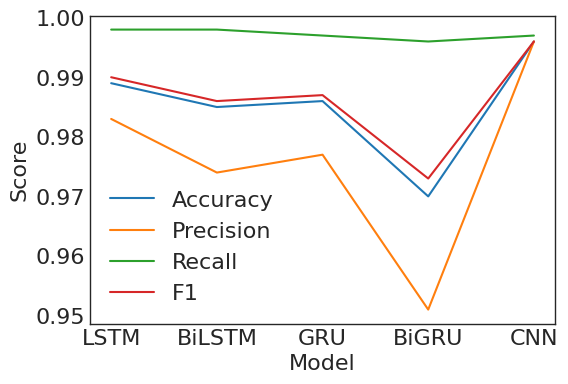

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
for col in ['Accuracy','Precision', 'Recall', 'F1']:
  ax.plot(df['Model'], df[col], label=col)
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(go.Scatter( x=df['Model'], y=df['Accuracy'], name="Accuracy"),secondary_y=False,)
fig.add_trace(go.Scatter( x=df['Model'], y=df['Precision'], name="Precision"),secondary_y=False,)
fig.add_trace(go.Scatter( x=df['Model'],y=df['Recall'], name="Recall"),secondary_y=False,)
fig.add_trace(go.Scatter( x=df['Model'],y=df['F1'], name="F1"),secondary_y=False,)
fig.update_xaxes(title_text="<b>Model</b>")
fig.update_yaxes(title_text="<b>Score</b>", secondary_y=False)
fig.update_layout(width=600, height=400)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=.21,y=.1))
fig.show()

###Plot

In [ ]:
!pip install scikit-plot==0.3.7
import scikitplot as skplt
import seaborn as sns
import numpy as np

In [ ]:
H=np.load('/content/drive/MyDrive/PhD/models/model_History_CNN.npy',allow_pickle='TRUE').item()
y_pred = cnn_y_pred

NameError: name 'cnn_y_pred' is not defined

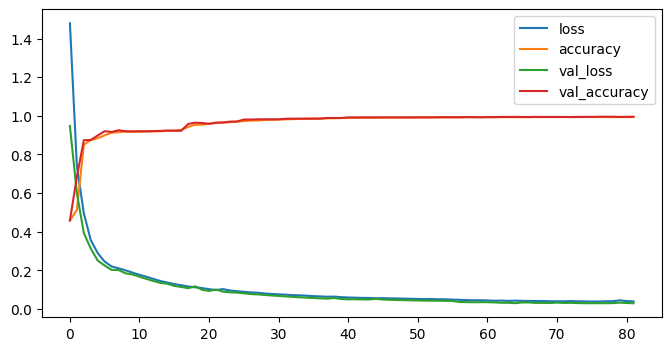

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(H).plot(figsize=(8,4))
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(go.Scatter( y=H['val_loss'], name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter( y=H['loss'], name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter( y=H['val_accuracy'], name="val accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter( y=H['accuracy'], name="val accuracy"), secondary_y=True,)
# Add figure title
# Set x-axis title
fig.update_xaxes(title_text="<b>Epoch</b>")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Loss</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=True)
# Set graph size (width and height in pixels)
fig.update_layout(width=600, height=400)  # Adjust these values as desired
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=.71,y=.5))
fig.show()

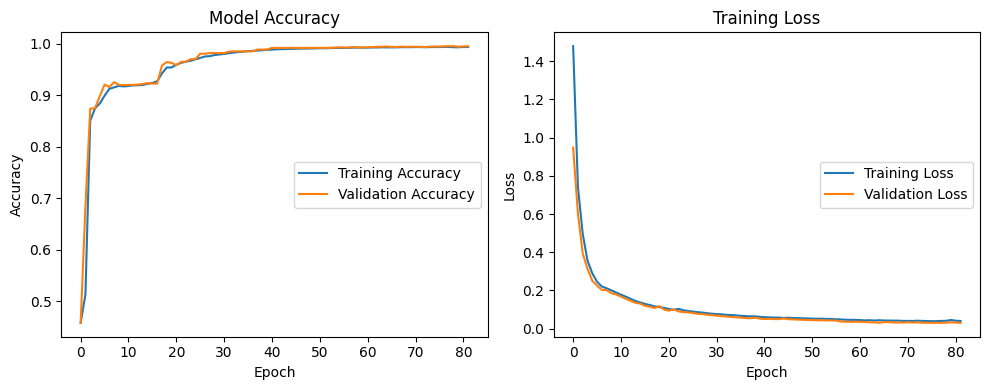

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((10, 4))
# summarize history for accuracy
ax1.set_title('Model Accuracy')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(H['accuracy'])
ax1.plot(H['val_accuracy'])
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
# summarize history for loss
ax2.set_title('Training Loss')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(H['loss'])
ax2.plot(H['val_loss'])
ax2.legend(['Training Loss', 'Validation Loss'], loc='center right')
fig.tight_layout()
fig.savefig('my_plot.png')

<ipython-input-206-73c9c9a646c4>:19: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



<Axes: >

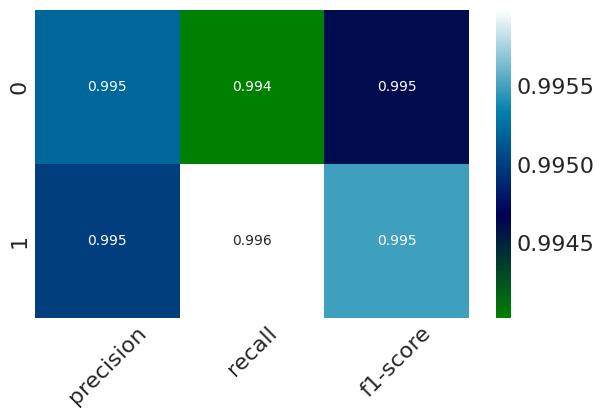

In [ ]:
from sklearn.metrics import classification_report
clf_report =classification_report(y_test, y_pred,output_dict=True )
import matplotlib.pyplot as plt
little = 11
medium = 16
large = 21
huge = 25

params = {"axes.titlesize": large,
          "figure.titlesize": huge,
          "legend.fontsize": medium,
          "figure.figsize": (12, 10),
          "axes.labelsize": medium,
          "axes.titlesize": medium,
          "xtick.labelsize": medium,
          "ytick.labelsize": medium,
          "axes.grid": True }
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(7,4))
#plt.title('Classification Report')
plt.tight_layout()
plt.xticks(np.arange(3), ['precision', 'recall', 'f1-score'], rotation=45)
#plt.yticks(np.arange(3), ['0', '1', 'Accuracy'], rotation=90)
import seaborn as sns
clf_report.pop('accuracy')
clf_report.pop('macro avg')
clf_report.pop('weighted avg')
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, 0:3].T,cmap='ocean', annot=True, fmt='.3f')

In [ ]:
clf_report =classification_report(y_test, y_pred,output_dict=True )
clf_report.pop('accuracy')

clf_report

{'0': {'precision': 0.9952047130819994,
  'recall': 0.9940244041509865,
  'f1-score': 0.99461420844839,
  'support': 43845},
 '1': {'precision': 0.9949951288467783,
  'recall': 0.9959844732967474,
  'f1-score': 0.995489555262504,
  'support': 52297},
 'macro avg': {'precision': 0.9950999209643889,
  'recall': 0.995004438723867,
  'f1-score': 0.995051881855447,
  'support': 96142},
 'weighted avg': {'precision': 0.995090708518444,
  'recall': 0.9950905951613239,
  'f1-score': 0.9950903584383812,
  'support': 96142}}

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

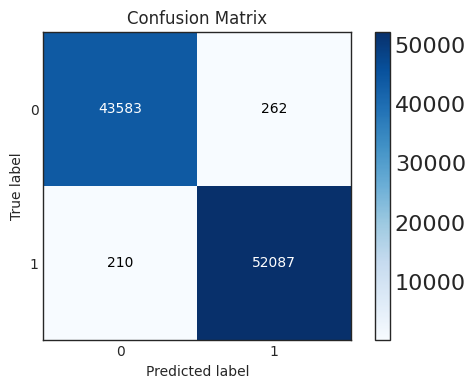

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(6,4))

###Test

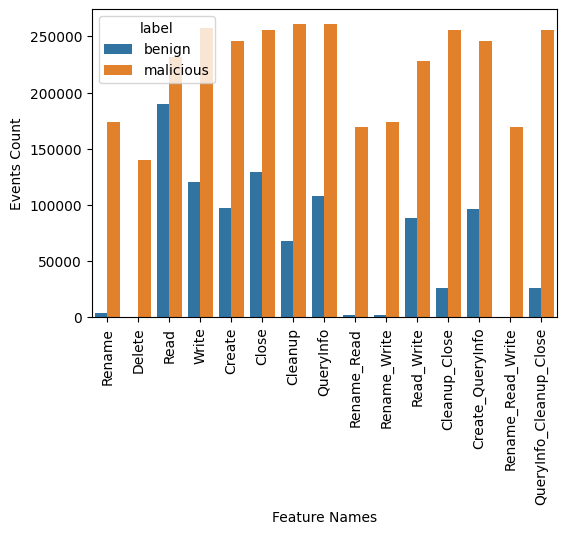

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
Encoded_events = pd.read_csv('/content/drive/MyDrive/PhD/processedEvents/Encoded_events.csv')
df = Encoded_events[['Rename','Delete','Read','Write','Create','Close','Cleanup','QueryInfo','Rename_Read','Rename_Write','Read_Write','Cleanup_Close','Create_QueryInfo','Rename_Read_Write','QueryInfo_Cleanup_Close','label']]
ff = df.groupby('label').sum()
transposed_ff = ff.transpose().reset_index()
melted_df = transposed_ff.melt(id_vars='index', var_name='label', value_name='count')
melted_df['label'] = melted_df['label'].replace({0: 'benign', 1: 'malicious'})
plt.figure(figsize=(6, 4))
sns.barplot(x='index', y='count', hue='label', data=melted_df)
plt.xticks(np.arange(15), ['Rename','Delete','Read','Write','Create','Close','Cleanup','QueryInfo','Rename_Read','Rename_Write','Read_Write','Cleanup_Close','Create_QueryInfo','Rename_Read_Write','QueryInfo_Cleanup_Close'], rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Events Count')
plt.show()

<Axes: >

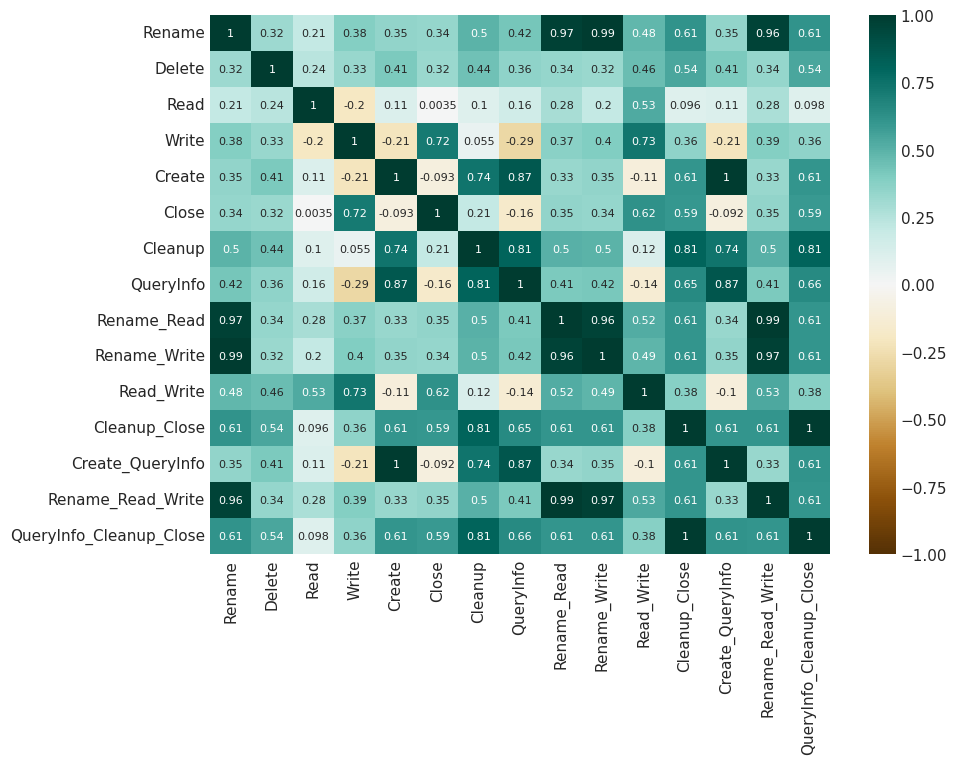

In [ ]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
little = 11
medium = 16
large = 21
huge = 25
params = {"axes.titlesize": little,
          "figure.titlesize": medium,
          "legend.fontsize": little,
          "figure.figsize": (10, 7),
          "axes.labelsize": little,
          "axes.titlesize": little,
          "xtick.labelsize": little,
          "ytick.labelsize": little,
          "axes.grid": True }
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
pd.set_option("display.float_format", lambda x: "%0.4f" % x)
np.set_printoptions(suppress=True)
import seaborn as sns
df.drop('label', axis=1, inplace=True)
sns.heatmap(df.corr(), cmap="BrBG", vmin=-1, vmax=1, annot=True , annot_kws={'fontsize':8})

In [ ]:
from keras.models import save_model,load_model
model_CNN=load_model("/content/drive/MyDrive/PhD/models/model_CNN")

In [ ]:
test_loss, test_accuracy = model_CNN.evaluate(padded_sequences_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3005/3005 [==============================] - 11s 4ms/step - loss: 0.0310 - accuracy: 0.9959
Test Loss: 0.031001422554254532
Test Accuracy: 0.9958810806274414


In [ ]:
fitted = model_CNN.predict(padded_sequences_test)

3005/3005 [==============================] - 10s 3ms/step


In [ ]:
fitted.flatten()

array([1.5876067, 0.       , 0.       , ..., 1.6802686, 0.       ,
       1.4155552], dtype=float32)

In [ ]:
import pickle as pkl
with open('fitted.pkl', 'wb') as f:
    pkl.dump(fitted, f)
with open('y_train.pkl', 'wb') as f:
    pkl.dump(y_train, f)

In [ ]:
import pickle as pkl
with open('fitted.pkl', 'rb') as f:
    fitted = pkl.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pkl.load(f)